# Russian - Solution Lesson 6 on Fast.ai
> Abbreviated solution of the lesson 6 on fast.ai

- toc: true
- branch: master
- badges: true
- comments: true
- author: Zmey56
- categories: [russian, fast.ai, solution]

In [ ]:
#hide
!pip install fastai --upgrade
import fastbook
fastbook.setup_book()

Requirement already up-to-date: fastai in /opt/conda/envs/fastai/lib/python3.8/site-packages (2.1.10)


In [ ]:
#hide
from fastbook import *

# Другие Проблемы С Компьютерным Зрением

В предыдущей главе вы познакомились с некоторыми важными практическими приемами обучения моделей на практике. Такие соображения, как выбор скорости обучения и количества эпох, очень важны для получения хороших результатов.

В этой главе мы рассмотрим два других типа проблем компьютерного зрения:многозначную классификацию и регрессию. Первый - это когда вы хотите предсказать более одной метки (а иногда и вовсе ни одной), а второй—когда ваши метки представляют собой одно или несколько чисел (количество, а не категорию).

В процессе будет более глубоко изучаться выходная активация, цели и функции потерь в моделях глубокого обучения.

## Классификация С Несколькими Метками

Классификация с несколькими метками относится к проблеме идентификации категорий объектов на изображениях. В классах, которые вы ищете, может быть несколько типов объектов, а может и вовсе не быть объектов.

На практике мы не видели много примеров, когда люди обучали мультиметочные классификаторы для этой цели, но мы очень часто видим, как пользователи и разработчики жалуются на эту проблему. Похоже, что это простое решение совсем не широко понимается и не ценится! Поскольку на практике, вероятно, чаще встречаются некоторые изображения с нулевым совпадением или более чем одним совпадением, мы, вероятно, должны ожидать на практике, что классификаторы с несколькими метками более широко применимы, чем классификаторы с одной меткой.

Сначала давайте посмотрим, как выглядит набор данных с несколькими метками, а затем объясним, как подготовить его для нашей модели. Вы увидите, что архитектура модели не изменилась по сравнению с предыдущей главой; изменилась только функция потерь. Начнем с данных.

### Данные

В нашем примере мы будем использовать набор данных PASCAL, который может содержать более одного вида классифицируемых объектов на изображение.

Мы начинаем с загрузки и извлечения набора данных как обычно:

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

Этот набор данных отличается от тех, которые мы видели раньше, тем, что они не структурирован по имени файла или папке, а вместо этого предоставляются CSV-файлом (значения, разделенные запятыми), сообщающим нам, какие метки использовать для каждого изображения. Мы можем проверить CSV-файл, прочитав его в DataFrame Pandas:

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


Как вы можете видеть, список категорий на каждом изображении отображается в виде строки, разделенной пробелами.

### Sidebar: Pandas и DataFrames

Нет, на самом деле это не панда! Pandas-это библиотека Python, которая используется для обработки и анализа табличных данных и данных временных рядов. Основным классом является DataFrame, который представляет собой таблицу состоящую из строк и столбцов. Вы можете получить DataFrame из CSV-файла, таблицы базы данных, словарей Python и многих других источников. В Jupiter DataFrame  выводится в виде форматированной таблицы, как показано здесь.

Вы можете получить доступ к строкам и столбцам DataFrame с помощью свойства iloc, как если бы это была матрица:

In [ ]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

Вы также можете получить столбец по имени, непосредственно индексируя DataFrame:

In [ ]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [ ]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### Построение DataBlock

Как мы преобразуем объект DataFrame в объект DataLoaders? Обычно мы предлагаем использовать API блока данных для создания объекта DataLoaders, где это возможно, поскольку он обеспечивает хорошее сочетание гибкости и простоты. Здесь мы покажем вам шаги, которые мы предпринимаем, чтобы использовать API блоков данных для построения объекта DataLoaders на практике, используя этот набор данных в качестве примера.

Как мы уже видели, PyTorch и fastai имеют два основных класса для представления и доступа к обучающему набору или набору проверки:

* Dataset:: Коллекция, которая возвращает кортеж вашей независимой и зависимой переменной для одного элемента
* DataLoader:: Итератор, который обеспечивает поток мини-пакетов, где каждый мини-пакет является кортежем пакета независимых переменных и пакета зависимых переменных

Кроме того, fastai предоставляет два класса для объединения ваших обучающих и проверочных наборов:

* Datasets:: Объект, содержащий обучающий набор данных и проверочный набор данных
* DataLoaders:: Объект, содержащий обучающий загрузчик данных и загрузчик данных проверки

Поскольку DataLoader строится поверх Dataset и добавляет к нему дополнительные функции (сортировка нескольких элементов в мини-пакет), часто проще всего начать с создания и тестирования Datasets, а затем посмотреть на DataLoaders после того, как они заработают.

Когда мы создаем DataBlock, мы создаем его постепенно, шаг за шагом, и используем блокнот для проверки ваших данных. Это отличный способ убедиться, что вы следите за любыми проблемами. Легко отлаживать, потому что вы знаете, что если возникает проблема, то она находится в строке кода, который вы только что набрали!

Начнем с простейшего случая, который представляет собой блок данных, созданный без параметров:

In [ ]:
dblock = DataBlock()

Из этого мы можем создать объект Datasets. Единственное, что нужно, - это источник-в данном случае наш DataFrame:

In [ ]:
dsets = dblock.datasets(df)

Он содержит тренировочный и проверочный набор данных, который мы можем индексировать:

In [ ]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [ ]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

Как вы можете видеть, возвращается строка DataFrame дважды. Это происходит потому, что по умолчанию блок данных предполагает, что у нас есть две вещи: входные данные и целевые значения. Нам нужно будет получить соответствующие поля из DataFrame, что мы можем сделать, передав функции get_x и get_y:

In [ ]:
x['fname']

'008663.jpg'

In [ ]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

Как вы можете видеть, вместо того, чтобы определять функцию обычным способом, мы используем ключевое слово Python lambda. Это просто кратчайший путь для определения и последующей ссылки на функцию. Следующий более подробный подход идентичен:

In [ ]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

Лямбда-функции отлично подходят для быстрой итерации, но они несовместимы с сериализацией, поэтому мы советуем вам использовать более подробный подход, если вы хотите экспортировать своего Learner после обучения (лямбды хороши, если вы просто экспериментируете).

Мы видим, что независимая переменная должна быть преобразована в полный путь, чтобы мы могли открыть ее как изображение, а зависимая переменная должна быть разделена символом пробела( который используется по умолчанию для функции разделения Python), чтобы она стала списком:

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/storage/data/pascal_2007/train/002844.jpg'), ['train'])

Чтобы действительно открыть изображение и выполнить преобразование его в тензоры, нам нужно будет использовать набор преобразований, которые нам предоставляют. Мы можем использовать те же типы блоков, что и раньше, за одним исключением: ImageBlock снова будет работать нормально, потому что у нас есть путь, который указывает на допустимое изображение, но CategoryBlock не будет работать. Проблема в том, что блок возвращает одно целое число, но нам нужно иметь возможность иметь несколько меток для каждого элемента. Чтобы решить эту проблему, мы используем MultiCategoryBlock. Этот тип блока ожидает получить список строк, как и в данном случае, поэтому давайте проверим его:

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

Как вы можете видеть, наш список категорий не закодирован таким же образом, как это было для обычного блока категорий. В том случае у нас было одно целое число, представляющее, какая это категория, основываясь на ее местоположении в нашем vocab. В этом случае, однако, у нас вместо этого есть список нулей с единицей. Например, если есть единица во второй и четвертой позициях, то это означает, что элементы vocab под номером два и четыре присутствуют на этом изображении. Это известно как one-hot encoding. Причина, по которой мы не можем просто использовать список индексов категорий, заключается в том, что каждый список будет иметь разную длину, а PyTorch требует тензоров одинаковой длины.

Давайте проверим, что представляют собой категории для этого примера (мы используем удобную функцию *torch.where*, которая возращает нам все индексы, где наше условие истинно или ложно):

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

С массивами NumPy, тензорами PyTorch и классом L fastai мы можем индексировать непосредственно с помощью списка или вектора, что делает большой код (например, этот пример) гораздо более ясным и кратким.

До сих пор мы игнорировали столбец is_valid, что означает, что блок данных по умолчанию использует случайное разделение. Чтобы явно выбрать элементы нашего набора проверки, нам нужно написать функцию и передать ее *splitter* (или использовать одну из предопределенных функций или классов fastai). Он будет принимать элементы (здесь весь наш фрейм данных) и должен возвращать два (или более) списка целых чисел:

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Как мы уже обсуждали, DataLoader  собирает элементы из Dataset в мини-пакет. Это кортеж тензоров, где каждый тензор просто куча элементов из местоположений в элементе Dataset.

Теперь, когда мы убедились, что отдельные элементы выглядят нормально, нам нужно сделать еще один шаг, чтобы убедиться, что мы можем создать наши DataLoaders, а именно убедиться, что каждый элемент имеет одинаковый размер. Для этого мы можем использовать *RandomResizedCrop*:

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

И теперь мы можем показать элемент наших данных:

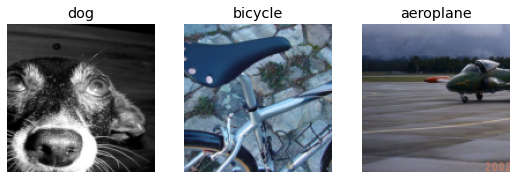

In [ ]:
dls.show_batch(nrows=1, ncols=3)

Помните, что если что-то пойдет не так при создании DataLoaders из вашего DataBlock или если вы хотите точно увидеть, что происходит с вашим DataBlock, вы можете использовать метод краткого изложения, который мы представили в предыдущей главе.

Наши данные теперь готовы для обучения модели. Как мы увидим, ничего не изменится, когда мы создадим нашего Learner, но за кулисами fastai библиотека выберет для нас новую функцию потерь: двоичную кросс-энтропию.

### Бинарная кросс-энтропия

Теперь создадим нашего Learner.

In [ ]:
learn = cnn_learner(dls, resnet18)

Мы также знаем, что модель в Learner, как правило, является объектом класса, наследуемого от nn.Module, и что мы можем вызвать его с помощью скобок, и он будет возвращать активации модели. Вы должны передать ему свою независимую переменную, как мини-пакет. Мы можем попробовать его, взяв мини-пакет из нашего загрузчика данных, а затем передав его модели:

In [ ]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

Подумайте о том, почему activs имеет такую форму—у нас есть размер пакета 64, и нам нужно рассчитать вероятность каждой из 20 категорий. Вот как выглядит одна из этих активаций:

In [ ]:
activs[0]

tensor([ 0.7476, -1.1988,  4.5421, -1.5915, -0.6749,  0.0343, -2.4930, -0.8330, -0.3817, -1.4876, -0.1683,  2.1547, -3.4151, -1.1743,  0.1530, -1.6801, -2.3067,  0.7063, -1.3358, -0.3715],
       grad_fn=<SelectBackward>)

Данные еще не масштабированы до 0 и 1

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

Обратите внимание, что поскольку у нас есть one-hot-encoded зависимая переменная, мы не можем напрямую использовать *nll_loss* или *softmax* (и поэтому мы не можем использовать *cross_entropy*):

* *softmax*, как мы знаем, требует, чтобы сумма всех предсказаний равнялась 1 и за счет использования exp значительно выделяет одну активацию из других. Однако у нас вполне может быть несколько объектов, которые имеются на изображении, поэтому ограничение максимальной суммы активаций до 1 не является хорошей идеей. Исходя из того же рассуждения, мы также можем хотеть, чтобы сумма была меньше 1, если мы не уверены что какая то категория появиться на изображении.
* *nll_loss*, как мы знаем, возвращает значение только одной активации: единственной активации, соответствующей одной метке для элемента. Это не имеет смысла, когда у нас есть несколько категорий.

С другой стороны, функция *binary_cross_entropy*, которая является просто mnist_loss вместе с log, обеспечивает именно то, что нам нужно, благодаря магии элементарных операций PyTorch. Каждая активация будет сравниваться с каждой целью для каждого столбца, поэтому нам не нужно ничего делать, чтобы заставить эту функцию работать для нескольких столбцов.

Python уже предоставляет нам эту функцию. На самом деле, он предоставляет ряд версий, с довольно запутанными названиями!

*F.binary_cross_entropy* и его модульный эквивалент *nn.BCELoss* вычисляют кросс-энтропию для одной one-hot-encoded цели, но не включают начальную сигмоиду. Обычно для one-hot-encoded целей вы захотите *F.binary_cross_entropy_with_logits* (или *НН.BCEWithLogitsLoss*), которые выполняют как сигмоидную, так и двоичную кросс-энтропию в одной функции, как в предыдущем примере.

Эквивалентом для наборов данных с одной меткой (например, MNIST или Pet dataset), где цель кодируется как одно целое число, является *F.nll_loss* или *nn.NLLLoss* для версии без начального softmax и *F.cross_entropy* или *nn.CrossEntropyLoss* для версии с начальным softmax.

Поскольку у нас есть цель с one-hot-encoded кодированием, мы будем использовать *BCEWithLogitsLoss*

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0342, grad_fn=<AliasBackward>)

На самом деле нам не нужно указывать fastai, что необходимо использовать эту функцию потерь (хотя мы можем, если захотим), так как она установлена автоматически. fastai знает, что DataLoaders имеют многокатегориальные метки, поэтому по умолчанию он будет использовать *nn.BCEWithLogitsLoss*.

Одно изменение по сравнению с предыдущей главой-это метрика, которую мы используем: поскольку это проблема с несколькими метками, мы не можем использовать функцию точности. Почему это? Ну, точность сравнивала наши результаты с нашими целями следующим образом:

```python
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()
```

Предсказанный класс был тем, у кого была самая высокая активация (это то, что делает argmax). Здесь это не работает, потому что у нас может быть более одного предсказания на одном изображении. После применения сигмоиды к нашим активациям (чтобы сопоставить их между 0 и 1), нам нужно решить, какие из них являются 0, а какие 1 за счет порога. Каждое значение выше порога будет рассматриваться как 1, а каждое значение ниже порога будет считаться 0:

```python
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

Если мы передадим accuracy_multi непосредственно в качестве метрики, она будет использовать значение по умолчанию для порога, которое равно 0,5. Возможно мы захотим изменить это значение по умолчанию и создать новую версию accuracy_multi, которая имеет другое значение по умолчанию. Чтобы помочь в этом, в Python есть функция, называемая partial. Это позволяет нам связать функцию с некоторыми аргументами, создавая новую версию этой функции, которая, когда бы она ни вызывалась, всегда включает эти аргументы. Например, вот простая функция, принимающая два аргумента:

In [ ]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

Мы можем переключиться на французскую версию этой функции с помощью partial:

In [ ]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

Теперь мы можем тренировать нашу модель. Давайте попробуем установить порог точности для нашей метрики равным 0,2:

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.940148,0.697462,0.236952,00:12
1,0.822964,0.557433,0.286056,00:12
2,0.602061,0.198278,0.833446,00:12
3,0.358782,0.123523,0.944383,00:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.130395,0.112252,0.949342,00:14
1,0.116924,0.105566,0.952171,00:14
2,0.097506,0.101672,0.951912,00:14


Выбор порога очень важен. Если вы выберете слишком низкий порог, вы часто не сможете выбрать правильно объекты. Мы можем увидеть это, изменив нашу метрику, а затем вызвав validate, который возвращает ошибку проверки и метрики:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10167204588651657,0.9306574463844299]

Если вы выберете слишком высокий порог, вы будете получать только те объекты, для которых ваша модель очень уверена:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10167204588651657,0.9425497055053711]

Мы можем найти лучший порог, попробовав несколько уровней и увидев, что работает лучше всего. Это намного быстрее, если мы просто возьмем предсказания один раз:

In [ ]:
preds,targs = learn.get_preds()

Тогда мы можем вызвать метрику напрямую. Обратите внимание, что по умолчанию get_press применяет для нас результирующую функцию активации (в данном случае сигмоида), поэтому нам нужно будет сказать accuracy_multi, чтобы он ее не применял:

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.9574)

Теперь мы можем использовать этот подход для поиска наилучшего порогового уровня:

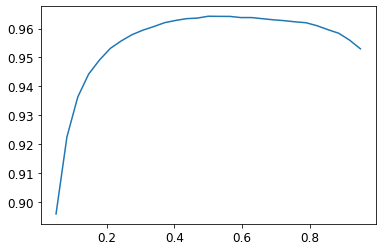

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

В этом случае мы используем проверочный набор для выбора гиперпараметра (порога), который является его задачей. Иногда студенты выражают озабоченность тем, что мы, возможно, можем переобучить проверочный набор, поскольку мы пробуем множество значений, чтобы увидеть, какое из них является лучшим. Однако, как вы видите на графике, изменение порога в этом случае приводит к плавной кривой, поэтому мы явно не выбираем какой-то неуместный выброс. Это хороший пример того, где вы должны быть осторожны с различием между теорией (не пытайтесь использовать много значений гиперпараметров, иначе вы можете переобучить) и практикой (если связь гладкая, то это нормально).

На этом заканчивается часть этой главы, посвященная классификации с несколькими метками. Далее мы рассмотрим проблему регрессии.

## Регрессия

Легко представить себе, что модели глубокого обучения делятся на такие области, как компьютерное зрение, НЛП и так далее. И действительно, именно так fastai классифицирует свои приложения-в основном потому, что именно так большинство людей привыкли думать о вещах.

Но на самом деле за этим скрывается более интересная и глубокая перспектива. Модель определяется ее независимыми и зависимыми переменными, а также функцией потерь. Это означает, что на самом деле существует гораздо более широкий спектр моделей, чем просто разделение на основе области. Возможно, у нас есть независимая переменная, которая является изображением, и зависимая, которая является текстом (например, генерируя подпись из изображения); или, возможно, у нас есть независимая переменная, которая является текстом, и зависимая, которая является изображением (например, генерируя изображение из подписи—что на самом деле возможно для глубокого обучения!); или, возможно, у нас есть изображения, тексты и табличные данные в качестве независимых переменных, и мы пытаемся предсказать покупку продукта... возможности действительно безграничны.

Возможность выйти за рамки фиксированных приложений, чтобы создавать свои собственные новые решения для новых проблем, помогает  понять API блоков данных (и, возможно, также API среднего уровня, который мы увидим позже в этой книге). В качестве примера рассмотрим проблему регрессии изображений. Это относится к обучению на основе набора данных, где независимая переменная представляет собой изображение, а зависимая переменная-одно или несколько чисел типа float. Часто мы видим, что люди относятся к регрессии изображений как к целому отдельному приложению, но, как вы увидите здесь, мы можем рассматривать его как просто еще один CNN поверх API блока данных.

Мы сразу перейдем к довольно сложному варианту регрессии изображений, потому что мы знаем, что вы к этому готовы! Мы собираемся сделать модель ключевой точки. Ключевой момент относится к определенному месту, представленному на изображении—в этом случае мы будем использовать изображения людей и будем искать центр лица человека на каждом изображении. Это означает, что мы фактически будем предсказывать два значения для каждого изображения: строку и столбец центра лица.

### Assemble the Data

Мы будем использовать [Biwi Kinect Head Pose dataset](https://icu.ee.ethz.ch/research/datsets.html) для этого раздела. Начнем с загрузки набора данных как обычно

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
#hide
Path.BASE_PATH = path

Давайте посмотрим, что у нас есть!

In [ ]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

Есть 24 каталога, пронумерованные от 01 до 24 (они соответствуют разным сфотографированным людям), и соответствующий файл .obj для каждого (они нам здесь не понадобятся). Давайте заглянем в один из этих каталогов:

In [ ]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Внутри подкаталогов у нас есть разные фреймы, каждый из которых поставляется с изображением (\_rgb.jpg) и файлом позы (\_pose.txt). Мы можем легко получить все файлы изображений рекурсивно с помощью get_image_files, а затем написать функцию, которая преобразует имя файла изображения в связанный с ним файл позы:

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('16/frame_00182_pose.txt')

Давайте взглянем на наше первое изображение:

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

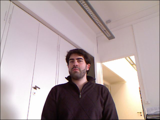

In [ ]:
im.to_thumb(160)

Веб-сайт набора данных Biwi используется для объяснения формата связи текстового файла post с каждым изображением, который показывает расположение центра головы. Детали этого не важны для наших целей, поэтому мы просто покажем функцию, которую мы используем для извлечения центральной точки головы:

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

Мы можем передать эту функцию DataBlock как get_y, так как она отвечает за маркировку каждого элемента. Мы изменим размер изображений до половины их входного размера, просто чтобы немного ускорить обучение.

Один важный момент, который следует отметить, заключается в том, что мы не должны просто использовать случайный сплиттер. Причина этого заключается в том, что одни и те же люди появляются на нескольких изображениях в этом наборе данных, но мы хотим убедиться, что наша модель может обобщать людей, которых она еще не видела. Каждая папка в наборе данных содержит изображения для одного человека. Поэтому мы можем создать функцию splitter, которая возвращает true только для одного человека, в результате чего набор проверки содержит только изображения этого человека.

Единственное другое отличие от предыдущих примеров блоков данных состоит в том, что второй блок является точечным блоком. Это необходимо для того, чтобы fastai знал, что метки представляют координаты; таким образом, он знает, что при увеличении данных он должен делать то же самое увеличение для координат, что и для изображений:

In [ ]:
get_ctr(img_files[0])

tensor([324.0023, 251.5637])

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

Прежде чем делать какое-либо моделирование, мы должны посмотреть на наши данные, чтобы убедиться, что все в порядке:

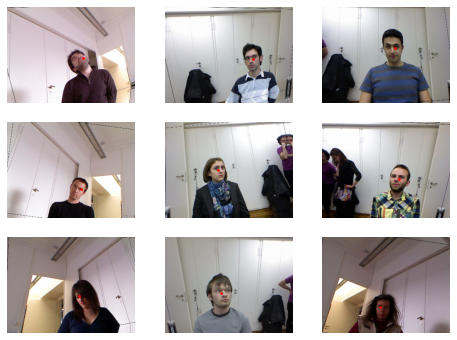

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

Это выглядит хорошо! Помимо визуального просмотра пакета, неплохо также посмотреть на лежащие в его основе тензоры (особенно если вы студент; это поможет прояснить ваше понимание того, что на самом деле видит ваша модель):

In [ ]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

((64, 3, 240, 320), (64, 1, 2))

Убедитесь, что вы понимаете, почему именно эти формы используются для наших мини-партий.

Вот пример одной строки из зависимой переменной:

In [ ]:
yb[0]

TensorPoint([[-0.2811, -0.0472]], device='cuda:0')

Как вы можете видеть, нам не нужно было использовать отдельное приложение регрессии изображений; все, что нам нужно было сделать, это пометить данные и сказать fastai, какие типы данных представляют независимые и зависимые переменные.

То же самое относится и к созданию нашего Learner. Мы будем использовать ту же функцию, что и раньше, с одним новым параметром,и будем готовы обучить нашу модель.

### Обучение модели

Как обычно, мы можем использовать cnn_learner для создания нашего ученика.

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

y_range реализуется в fastai с помощью sigmoid_range, который определяется как:

In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

Он устанавливается в качестве конечного слоя модели, если определен y_range. Подумайте о том, что делает эта функция и почему она заставляет модель выводить активации в диапазоне (lo,hi).

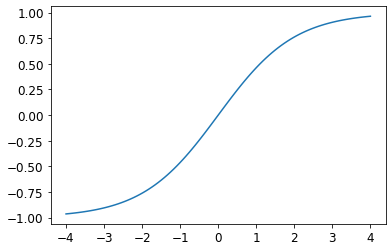

In [ ]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

Мы не указали функцию потерь и это означает fastai выбирает по умолчанию. Давайте посмотрим, что он выбрал для нас:

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

Это имеет смысл, поскольку, когда координаты используются в качестве зависимой переменной, большую часть времени мы, вероятно, пытаемся предсказать что-то как можно более близкое; это в основном то, что делает MSELoss (mean squared error loss). Если вы хотите использовать другую функцию потерь, вы можете передать ее cnn_learner с помощью параметра loss_func.

Обратите внимание также, что мы не указали никаких метрик. Это потому, что MSE уже является необходимой метрикой для этой задачи (хотя она, вероятно, более интерпретируема после того, как мы возьмем квадратный корень).

Мы можем выбрать лучшую скорость обучения с помощью искателя скорости обучения:

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.03981071710586548)

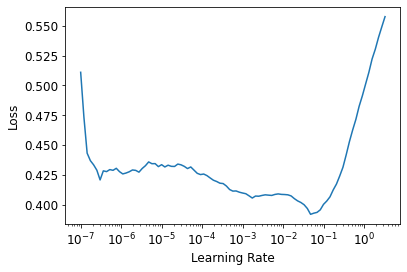

In [ ]:
learn.lr_find()

Мы попробуем LR 1e-2:

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.050240,0.016628,01:12


epoch,train_loss,valid_loss,time
0,0.007083,0.002008,01:30
1,0.002808,0.000214,01:31
2,0.001404,0.000119,01:31


Обычно, когда мы запускаем это, мы получаем потерю около 0,0001, что соответствует средней ошибке предсказания координат:

In [ ]:
math.sqrt(0.0001)

0.01

Это звучит очень точно! Но очень важно взглянуть на наши результаты с помощью *Learner.show_results*. Левая сторона-это фактические (истинные) координаты, а правая - предсказания нашей модели:

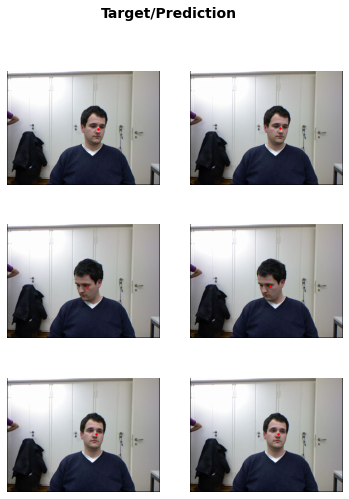

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

Просто удивительно, что всего за несколько минут вычислений мы создали такую точную модель ключевых точек и без какого-либо специального приложения для конкретной области. Это сила построения гибких API и использования трансфертного обучения! Особенно поразительно, что мы смогли так эффективно использовать трансферное обучение даже между совершенно разными задачами; наша предварительно обученная модель была обучена классификации изображений, и мы точно настроились на регрессию изображений.

## Заключение

В задачах, которые на первый взгляд совершенно различны (классификация с одной меткой, классификация с несколькими метками и регрессия), мы в конечном итоге используем одну и ту же модель с разным количеством выходов. Функция потерь-это единственное, что меняется, поэтому важно дважды проверить, что вы используете правильную функцию потерь для своей проблемы.

fastai автоматически попытается выбрать правильный вариант из построенных вами данных, но если вы используете чистый PyTorch для создания своих загрузчиков данных, убедитесь, что вы хорошо проработали вопрос о том, какую функцию потерь, и помните, что вы, скорее всего, захотите:

* nn.CrossEntropyLoss для классификации с одной меткой
* nn.BCEWithLogitsLoss для классификации с множесством меток
* nn.MSELoss для регрессии